In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# use y_finance to get the stock.
aapl = yf.download('AAPL', start="2020-01-01", end="2021-01-01")
# Calculate how many dates are in the file and add a column
aapl['Date_Id'] = (aapl.index.date - aapl.index.date.min()).astype('timedelta64[D]')
aapl['Date_Id'] = aapl['Date_Id'].dt.days + 1
aapl.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
# Add adj high and low, which may be important later
aapl['Adj_High'] = aapl['Adj_Close'] * aapl['High'] / aapl['Close']
aapl['Adj_Low'] = aapl['Adj_Close'] * aapl['Low'] / aapl['Close']
aapl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume,Date_Id,Adj_High,Adj_Low
Date,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,1,73.120237,71.804267
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800,2,73.115365,72.122918
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925652,118387200,5,72.964572,71.210758
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000,6,73.193203,72.361301
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,7,74.054304,72.283461


In [5]:
# Create a linear model from the close and date
data = aapl.filter(['Date_Id','Adj_Close'], axis=1)
data.insert(0, 'Ones', 1)
cols = data.shape[1]
X = data.iloc[:,0:cols-1] # iloc slicing function
X = np.asarray(X.values)
Y = data.iloc[:,cols-1:cols]
Y = np.asarray(Y.values)
theta = np.asarray([np.array([0,0])]).T
model = linear_model.LinearRegression(fit_intercept = False)
model.fit(X, Y)
model.coef_ # get theta coefficients (model params)

array([[59.40176287,  0.18456734]])

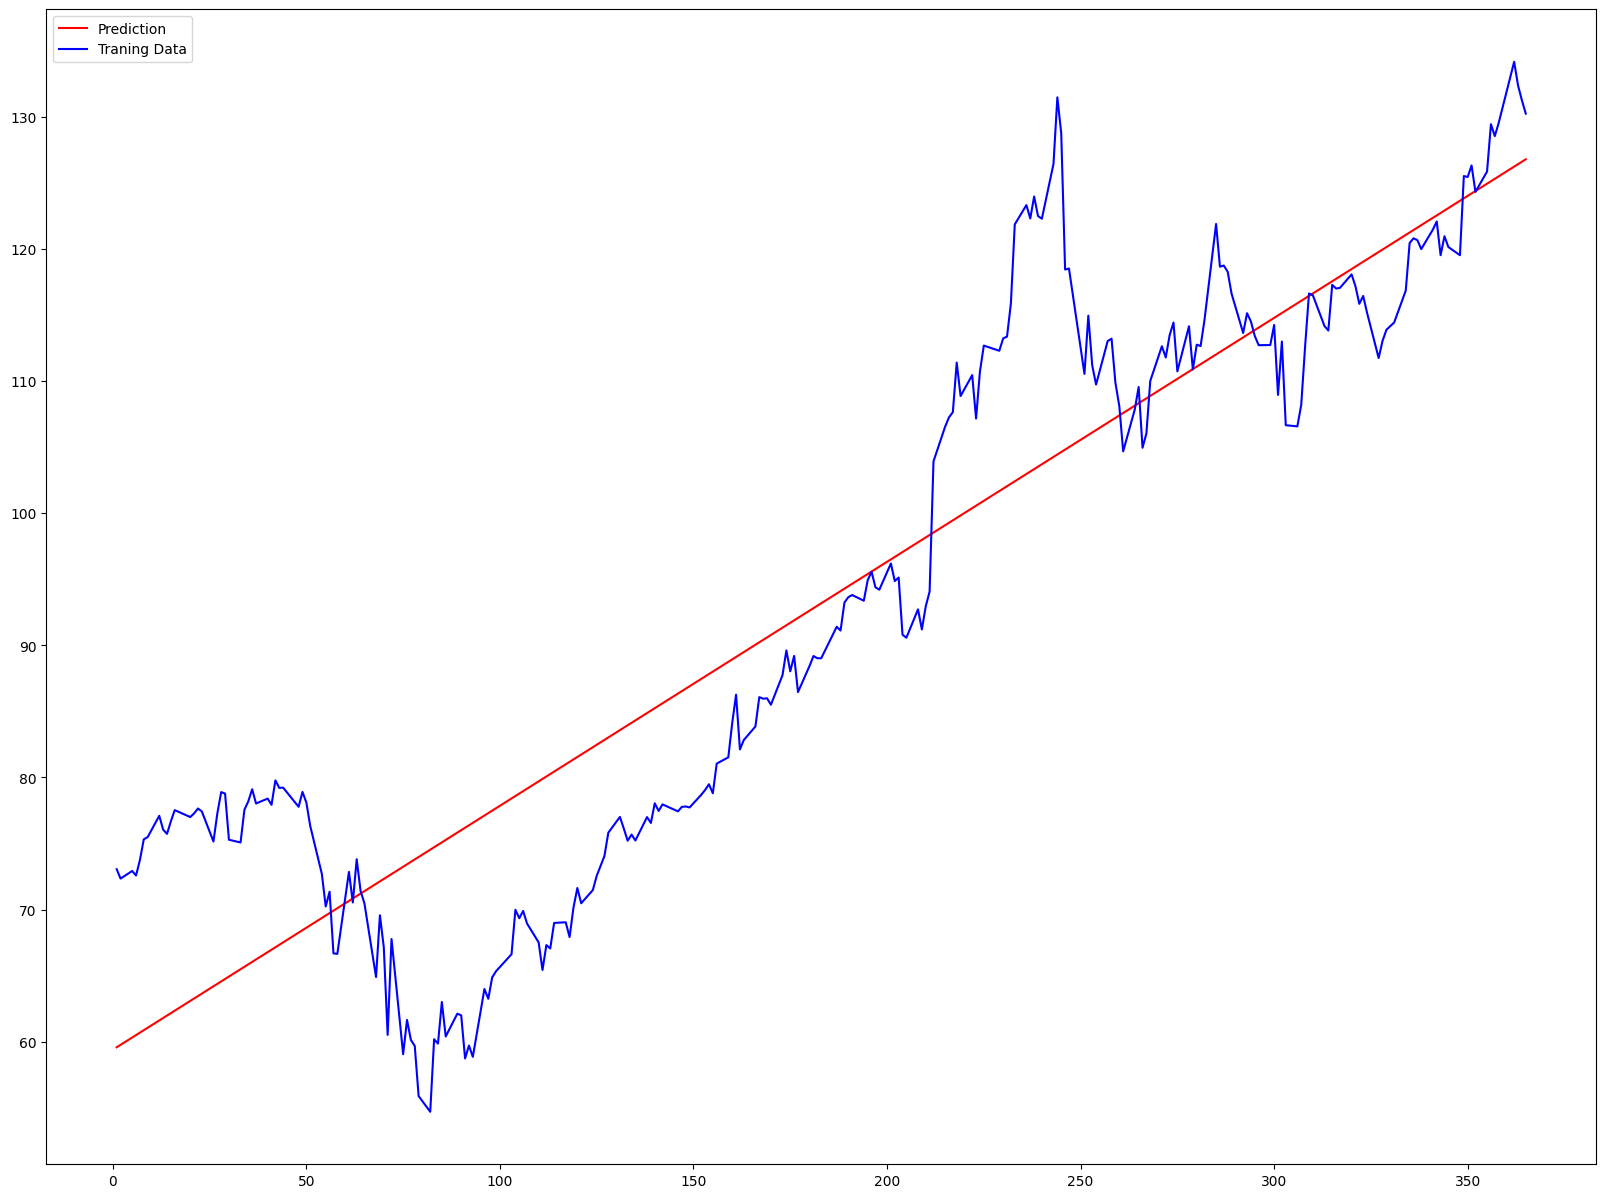

In [6]:
# Graph the model
x = np.array(np.ravel(X[:, 1]))
f = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(20,15))
ax.plot(x, f, color = "red", label='Prediction')
ax.plot(X[:, 1], Y, color = "blue", label='Traning Data')
ax.legend(loc=2)